# Titanic

Kaggle Challenge: https://www.kaggle.com/c/titanic

The data has been split into two groups:

- training set (train.csv)
- test set (test.csv)

For the training set, we provide the outcome (also known as the "ground truth") for each passenger. Your model will be based on "features" like passengers' gender and class.


The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold

## Loading Data

In [2]:
train_df = pd.read_csv(os.path.join("data", "train.csv"))
test_df = pd.read_csv(os.path.join("data","test.csv"))

In [6]:
data = pd.concat([train_df, test_df], keys=["train", "test"])

In [7]:
data.head()

age cabin embarked     fare  \
train 0  22.0   NaN        S   7.2500   
      1  38.0   C85        C  71.2833   
      2  26.0   NaN        S   7.9250   
      3  35.0  C123        S  53.1000   
      4  35.0   NaN        S   8.0500   

                                                      name  parch  pclass  \
train 0                            Braund, Mr. Owen Harris      0       3   
      1  Cumings, Mrs. John Bradley (Florence Briggs Th...      0       1   
      2                             Heikkinen, Miss. Laina      0       3   
      3       Futrelle, Mrs. Jacques Heath (Lily May Peel)      0       1   
      4                           Allen, Mr. William Henry      0       3   

            sex  sibsp  survived            ticket  
train 0    male      1       0.0         A/5 21171  
      1  female      1       1.0          PC 17599  
      2  female      0       1.0  STON/O2. 3101282  
      3  female      1       1.0            113803  
      4    male      0       0.0            373450

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1309 entries, (train, 0) to (test, 417)
Data columns (total 11 columns):
age         1046 non-null float64
cabin       295 non-null object
embarked    1307 non-null object
fare        1308 non-null float64
name        1309 non-null object
parch       1309 non-null int64
pclass      1309 non-null int64
sex         1309 non-null object
sibsp       1309 non-null int64
survived    891 non-null float64
ticket      1309 non-null object
dtypes: float64(3), int64(3), object(5)
memory usage: 123.3+ KB


In [9]:
data.describe()

,age,fare,parch,pclass,sibsp,survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,3.000000,0.000000,0.000000
75%,39.000000,31.275000,0.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,3.000000,8.000000,1.000000


Check how many data slots are empty

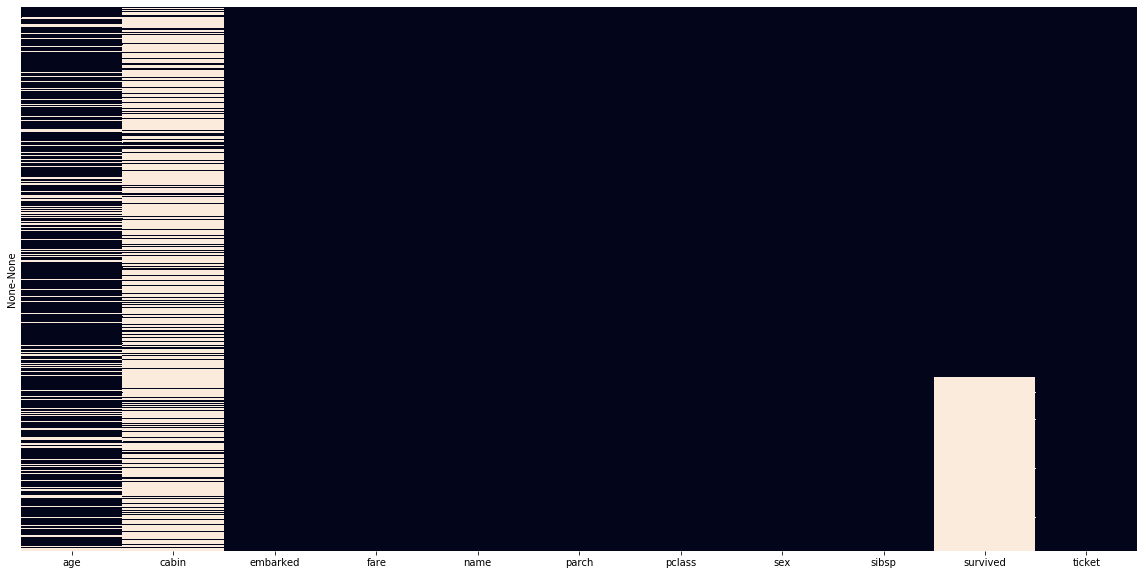

In [18]:
plt.rcParams["figure.figsize"] = (20, 10)

sns.heatmap(data.isnull(), yticklabels=False, cbar=False)

In [19]:
data = data.fillna(np.nan)

In [20]:
data.isnull().sum()

age          263
cabin       1014
embarked       2
fare           1
name           0
parch          0
pclass         0
sex            0
sibsp          0
survived     418
ticket         0
dtype: int64

Showing the Correlation Matrix for the data

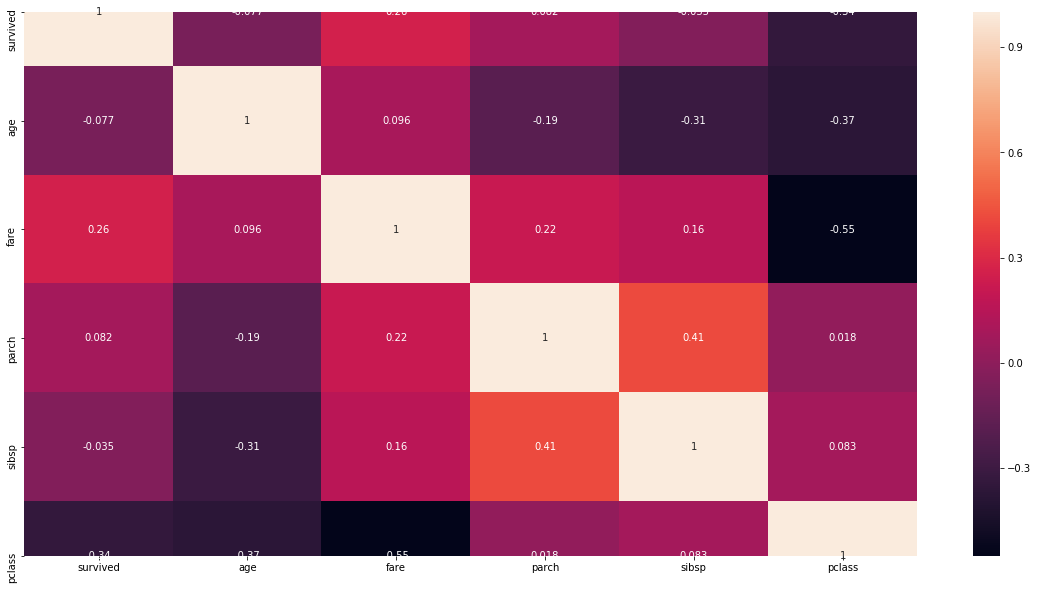

In [21]:
sns.heatmap(train_df[['survived', 'age', 'fare', 'parch', 'sibsp', 'pclass']].corr(), annot=True)

## Splitting Data

In [22]:
train_df.columns

Index(['survived', 'pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked'],
      dtype='object')

In [32]:
train_df.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [37]:
train_df.dtypes

survived      int64
pclass        int64
name         object
sex          object
age         float64
sibsp         int64
parch         int64
ticket       object
fare        float64
cabin        object
embarked     object
dtype: object

In [42]:
X_train = train_df.drop(['name', 'sex', 'ticket', 'cabin', 'embarked', 'survived'], axis=1).fillna(0)
y_train = train_df['survived']

In [34]:
test_df.columns

Index(['pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare',
       'cabin', 'embarked'],
      dtype='object')

In [43]:
X_test = test_df.drop(['name', 'sex', 'ticket', 'cabin', 'embarked'], axis=1).fillna(0)

## Models

In this notebook a various different models will be tested:
- Logistic Regression
- Decision Trees
- Random Forests
- SVM
- K Nearest Neighbours

Below are the model parameters which will be grid/random searched and we'll see which one performs better for a certain dataset.

In [30]:
random_seed = 1201
models = {
    "Logistic_Regression": {
        "model": LogisticRegression(random_state=random_seed),
        "alias": 'LReg',
        "params": {
            "C": [1, 0.1, 0.01, 0.001, 0.0001],
            "max_iter" : [100, 200],
            "solver": ['lbfgs', 'liblinear']
        }
    },
    "SVC": {
        "model": SVC(random_state=random_seed),
        "alias": 'SVC',
        "params": {
            "C": [1, 0.1, 0.01, 0.001, 0.0001],
            "kernel": ['linear', 'rbf'],
            "decision_function_shape": ['ovr', 'ovo'],
            "probability": [True]
        }
    },
    "Decision_Trees": {
        "model": DecisionTreeClassifier(random_state=random_seed),
        "alias": 'DTree',
        "params": {
            "criterion": ['gini', 'entropy'],
        }
    },
    "Random_Forest": {
        "model": RandomForestClassifier(random_state=random_seed),
        "alias": "RFT",
        "params": {
            "max_depth": [None],
            "max_features": [1, 3, 10, 'auto'],
            "min_samples_split": [2, 3, 10],
            "min_samples_leaf": [1, 3, 10],
            "bootstrap": [False],
            "n_estimators" :[100, 200, 300],
            "criterion": ["gini", "entropy"]
        }
    },
    "K_Nearest_Neighbours": {
        "model": KNeighborsClassifier(),
        "alias": 'KNN',
        "params": {
            "n_neighbors": list(range(2,40+1,2)),
            "weights": ['uniform', 'distance']
        }
    }
}

In [44]:
%%time
import time

n_jobs = 4
verbose_level = 0
use_quicker_search = False

kfold = StratifiedKFold(n_splits=10)
results = {}

for i, model_name in enumerate(models):
    start = time.time()
    print('({}/{}) {}: training model... '.format(i + 1, len(models), model_name), end="", flush=True)
    
    clf = models[model_name]['model']
    params = models[model_name]['params']
    
    if use_quicker_search:
        random_search = RandomizedSearchCV(clf, param_distributions=params, cv=kfold, n_iter=5, scoring='accuracy', n_jobs=n_jobs, verbose=verbose_level)
        random_search.fit(X_train, y_train)
        results[model_name] = random_search
    else:
        grid_search = GridSearchCV(clf, param_grid=params, cv=kfold, scoring='accuracy', n_jobs=n_jobs, verbose=verbose_level)
        grid_search.fit(X_train, y_train)
        results[model_name] = grid_search
    
    print('Time Taken: {}s\n'.format(time.time() - start))

(1/5) Logistic_Regression: training model... Time Taken: 3.0696208477020264s

(2/5) SVC: training model... Time Taken: 623.9439849853516s

(3/5) Decision_Trees: training model... Time Taken: 2.663860559463501s

(4/5) Random_Forest: training model... Time Taken: 205.9934024810791s

(5/5) K_Nearest_Neighbours: training model... Time Taken: 3.393261671066284s

Wall time: 13min 59s


In [55]:
results['K_Nearest_Neighbours'].best_params_

{'n_neighbors': 36, 'weights': 'uniform'}

The results are saved in a variable called ```model_results``` which are then viewed in the form of a graph (Bar Plot) and table (DataFrame).

In [88]:
model_results=[]
for model_name in results:
    results_model = results[model_name]
    score = results_model.cv_results_
    
    model_results.append({
        "model_name": model_name,
        "mean": np.nanmean(score["mean_test_score"]),
        "standard_deviation": np.nanmean(score["std_test_score"])
    })

model_results=pd.DataFrame(model_results, columns=['model_name', 'mean', 'standard_deviation'])
model_results

,model_name,mean,standard_deviation
0,Logistic_Regression,0.676408,0.044751
1,SVC,0.657418,0.035945
2,Decision_Trees,0.670069,0.046749
3,Random_Forest,0.714354,0.039610
4,K_Nearest_Neighbours,0.675896,0.054054


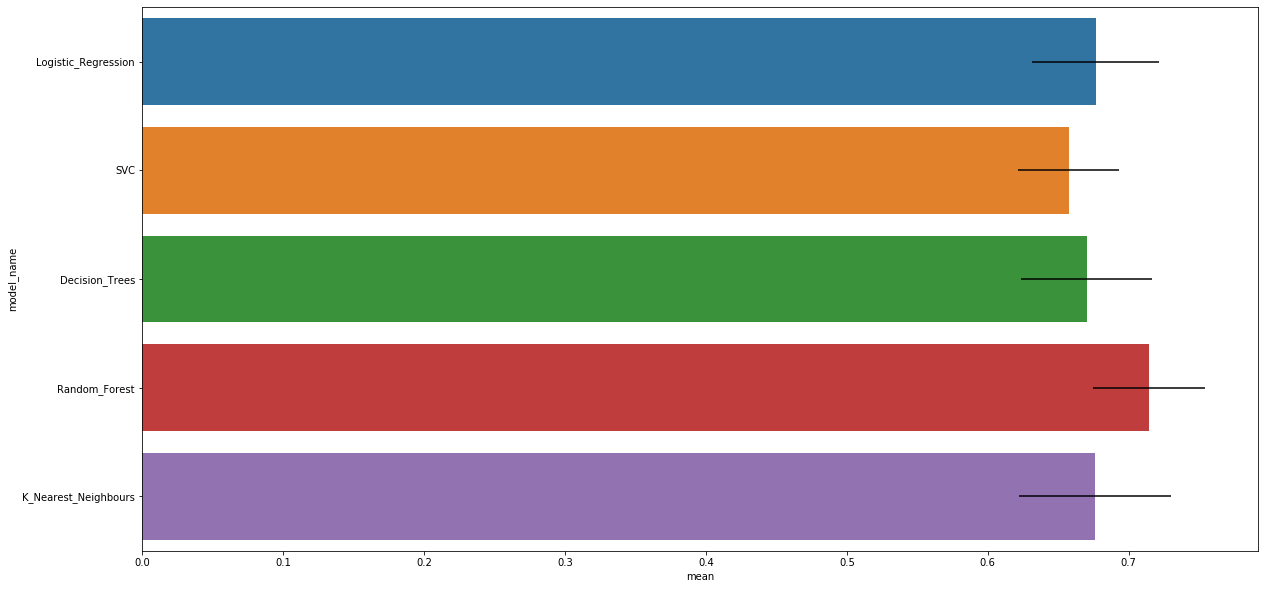

In [89]:
sns.barplot(data=model_results, y='model_name', x='mean', orient='h', **{'xerr':model_results['standard_deviation']})

The Predictions of the models are viewed, again, in the form of a table and a heatmap

In [91]:
predictions_models = {}

for model_name in results:
    best_model = results[model_name].best_estimator_
    predictions = best_model.predict(X_test)    
    predictions_models[model_name] = predictions

predictions_models = pd.DataFrame(predictions_models)
predictions_models

,Logistic_Regression,SVC,Decision_Trees,Random_Forest,K_Nearest_Neighbours
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,1,0,0
5,0,0,0,0,0
6,0,0,0,0,0
7,0,1,0,1,1
8,0,0,1,0,0
9,0,0,0,0,1


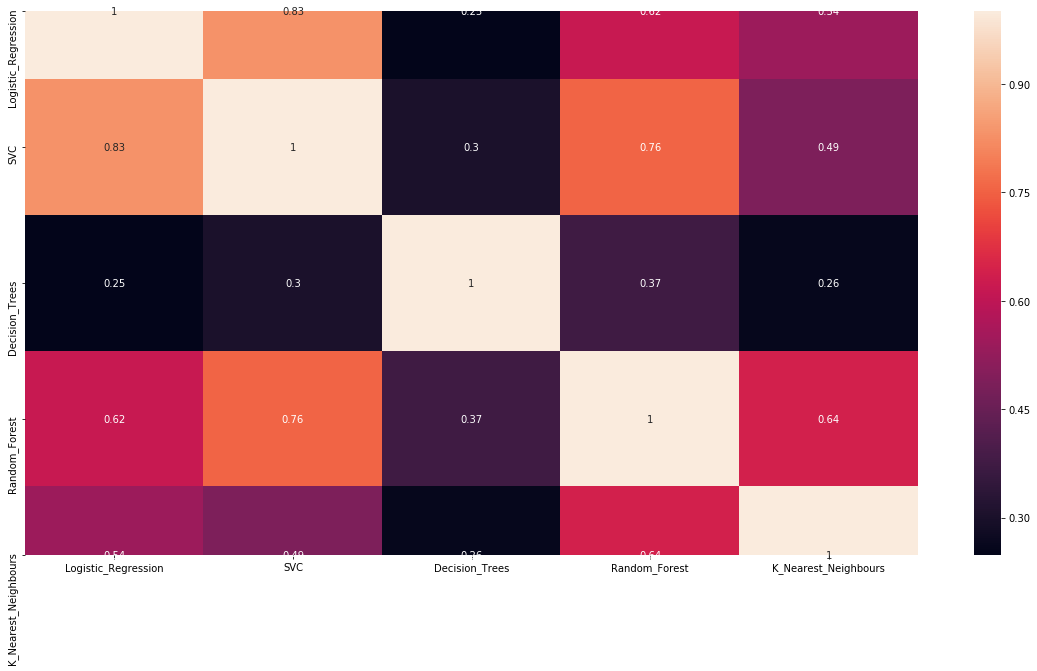

In [92]:
sns.heatmap(predictions_models.corr(), annot=True)